In [5]:
import os
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"

import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp
import lenspyx
import pysht
from pysht import get_geom
import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky

from mpl_toolkits.axes_grid1 import make_axes_locatable

# lmax, mmax = 511, 511
# lmax, mmax = 2047, 2047
lmax, mmax = 4095, 4095
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
# geominfo = ('tgl',{'lmax': lmax, 'smax':3})
# geominfo = ('gl',{'lmax':lmax})
solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) # if solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
# geominfo = ('cc',{'nphi':1032, 'ntheta':2058})
# geominfo = ('healpix',{'nside': 512})

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
Tskyalm = synsky.get_sim_sky(0, spin=0, space='alm', field='temperature')

/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH
INFO:: 03-30 10:25:10:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-30 10:25:10:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 03-30 10:25:10:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-30 10:25:10:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
CPU_SHT_DUCC_transformer.synthesis
  Input shape: [(), (8390656,), (), (), (), ()]
  Output shape: (1, 33554432)
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -1.79799868e-08-1.27456386e-08j
  1.31581772e-08-1.74100796e-08j -1.12260860e-08+2.16900048e-09j]
(1, 8390656) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -1.79799868e-08-1.27456386e-08j
   1.31581772e-08-1.74100796e-08j -1.

In [6]:
"""
gclm2lenmap
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

defres = {}
geominfo_CAR = ('cc',{'nphi':2*(lmax+1), 'ntheta':lmax+1})
for backend in ['CPU', 'GPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
        sht_solver = 'shtns' # 'shtns'
        tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)
    elif backend == 'CPU':
        solvers = ['duccnufft']
        sht_solver = 'ducc' # 'shtns'
        tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")
            defres.update({
            backend: t.gclm2lenmap(
            Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4, cc_transformer=tCAR, HAS_DUCCPOINTING=True, mode=2)})

Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
Running in debug mode
CPU_SHT_DUCC_transformer.synthesis
  Input shape: [(), (8390656,)]
  Output shape: (2, 33554432)
Testing solver=cufinufft backend=GPU mode=nuFFT...
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
deflection std is 2.58e+00 amin

----Testing function gclm2lenmap...----
Running in debug mode
CPU_SHT_DUCC_transformer.synthesis
  Input shape: [(), (1, 8390656)]
  Output shape: (1, 33554432)
GPU_cufinufft_transformer._synthCARgrid
  Input shape: [(1, 8390656)]
  Output shape: (1, 4096, 8192)
starting ctyping
done with ctyping
sta

CPU (1, 512, 1024)
----------
GPU (1, 512, 1024)
----------


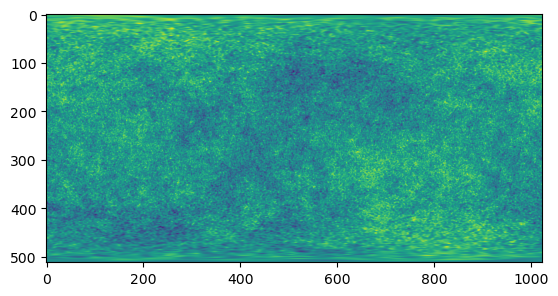

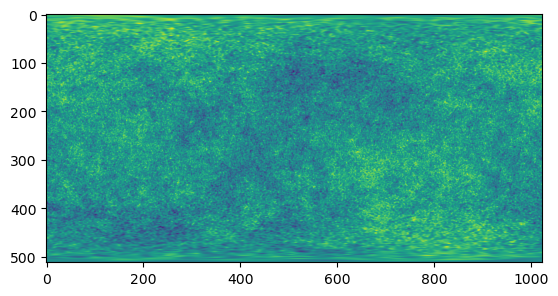

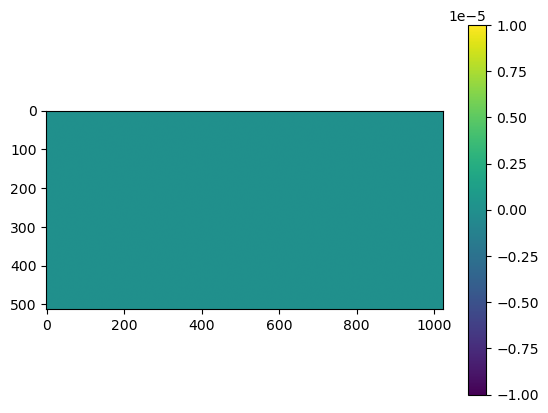

In [3]:
for k in defres:
    print(k, defres[k][0].shape)
    print('-'*10)
plt.imshow(defres['GPU'][0][0])
plt.show()
plt.imshow(defres['CPU'][0][0])
plt.show()
plt.imshow(defres['CPU'][0][0]-defres['GPU'][0][0], vmin=-1e-5, vmax=1e-5)
plt.colorbar()
plt.show()

CPU (1022, 1024)
----------
GPU (1022, 1024)
----------


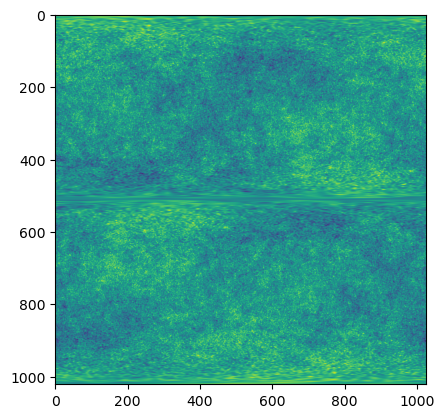

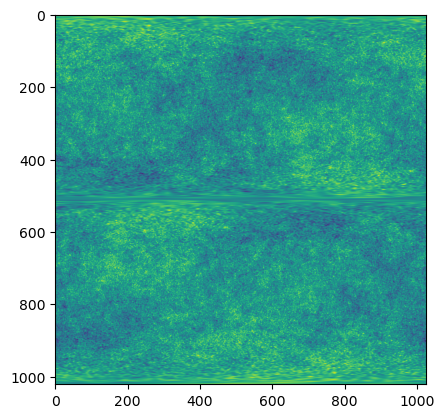

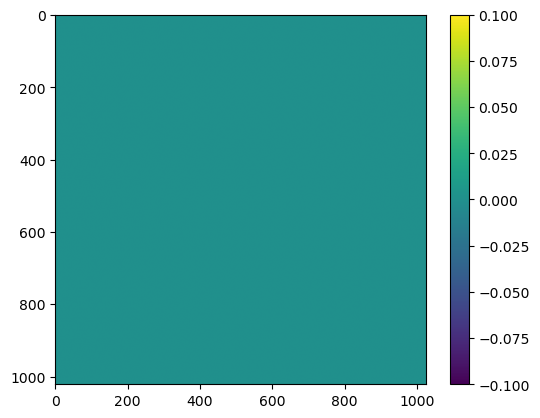

In [4]:
for k in defres:
    print(k, defres[k][1].shape)
    print('-'*10)
plt.imshow(defres['GPU'][1].real)
plt.show()
plt.imshow(defres['CPU'][1].real)
plt.show()
plt.imshow(defres['CPU'][1].real - defres['GPU'][1].real)
plt.colorbar()
plt.show()

CPU (1022, 1024)
----------
GPU (1022, 1024)
----------


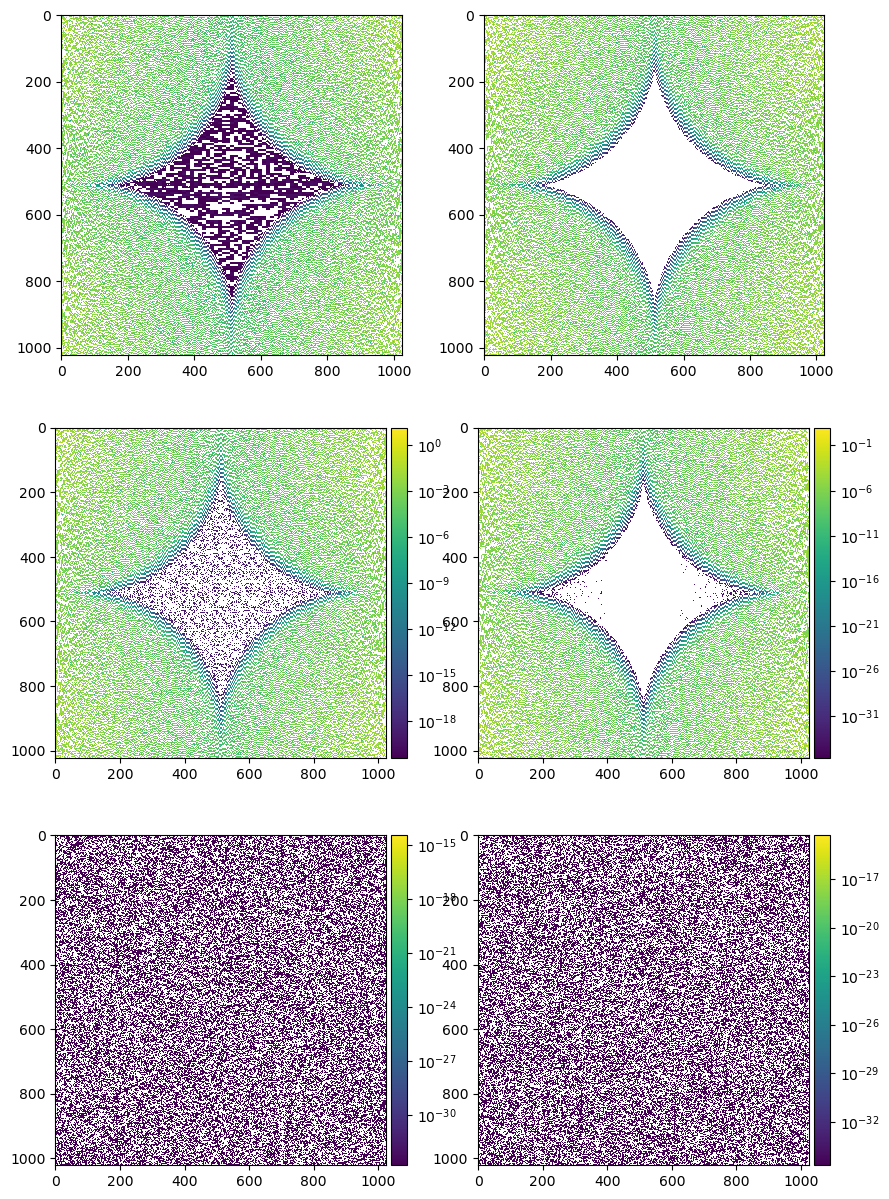

In [5]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

for k in defres:
    print(k, defres[k][2].shape)
    print('-'*10)
fig, ax = plt.subplots(3,2, figsize=(10,15))

ax[0,0].imshow(np.real(defres['CPU'][2]), norm='log')
ax[0,1].imshow(np.imag(defres['CPU'][2]), norm='log')

im = ax[1,0].imshow(np.real(defres['GPU'][2]), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(defres['GPU'][2]), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,0].imshow(defres['CPU'][2].real - defres['GPU'][2].real, norm='log')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(defres['CPU'][2].imag - defres['GPU'][2].imag, norm='log')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

CPU (524288, 2)
----------
GPU (524288, 2)
----------


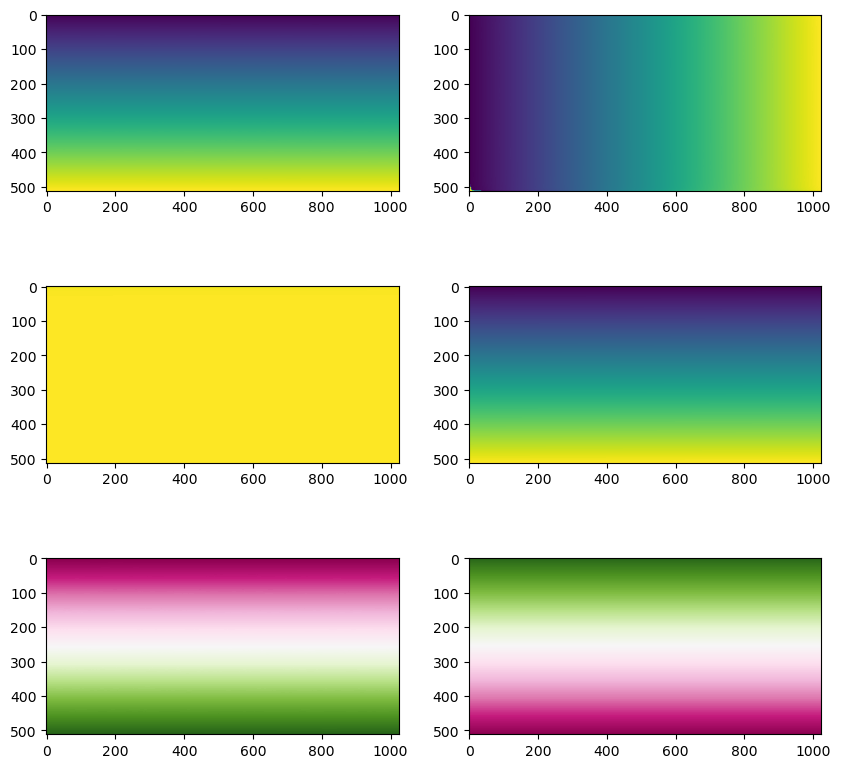

In [6]:
for k in defres:
    print(k, defres[k][3].shape)
    print('-'*10)
fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][3][:,0].reshape(lmax+1,-1))
ax[0,1].imshow(defres['CPU'][3][:,1].reshape(lmax+1,-1))

ax[1,0].imshow(defres['GPU'][3][:,0].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][3][:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][3][:,0].reshape(lmax+1,-1) - defres['GPU'][3][:,0].reshape(lmax+1,-1), cmap='PiYG')
ax[2,1].imshow(defres['CPU'][3][:,1].reshape(lmax+1,-1) - defres['GPU'][3][:,1].reshape(lmax+1,-1), cmap='PiYG')

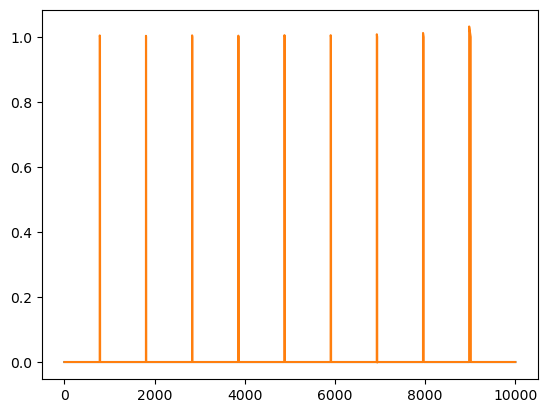

In [7]:
plt.plot(((defres['CPU'][3][:,0] - defres['GPU'][3][:,0])/defres['CPU'][3][:,0])[-10000:])
plt.plot(((defres['CPU'][3][:,1] - defres['GPU'][3][:,1])/defres['CPU'][3][:,1])[-10000:])

"differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'\n"

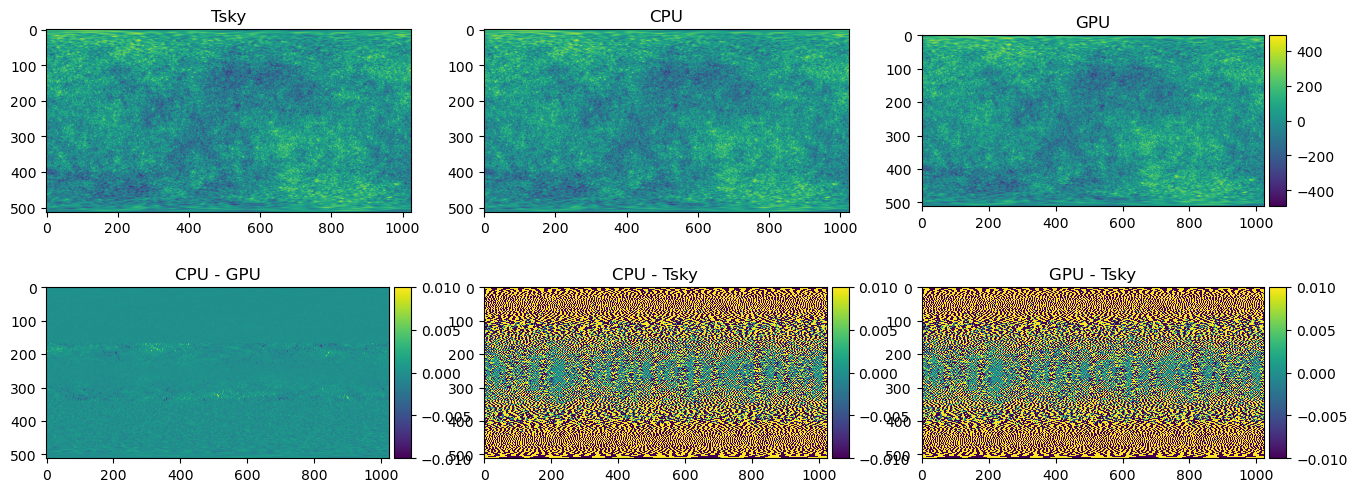

In [9]:
import cufinufft
import ducc0
def _nufft(fc, ptg):
    fcshifted = np.fft.fftshift(fc, axes=(0,1))
    data_ = cp.array(fcshifted.astype(np.complex128))
    # data_ = cp.array(fc.astype(np.complex128))
    x_ = cp.array(ptg[:,0])
    y_ = cp.array(ptg[:,1])
    v_ = cufinufft.nufft2d2(x=x_, y=y_, data=data_, isign=1)
    values = np.real(v_.get())
    return values

if True:
    # test pysht
    resCPU = defres['CPU'][4]
    resGPU = defres['GPU'][4]
else:
    # test this cell
    resCPU = ducc0.nufft.u2nu(grid=defres['CPU'][2], coord=defres['CPU'][3], forward=False, epsilon=1e-5, nthreads=4, verbosity=0, periodicity=2*np.pi, fft_order=True).real      
    resGPU = _nufft(defres['GPU'][2], defres['GPU'][3])

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1).real)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1))
ax[0,1].set_title('CPU')


im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1))
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow((resCPU.reshape(lmax+1,-1)-resGPU.reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((resCPU.reshape(lmax+1,-1)-Tsky.reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
ax[1,1].set_title('CPU - Tsky')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow((resGPU.reshape(lmax+1,-1)-Tsky.reshape(lmax+1,-1).real), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('GPU - Tsky')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# This is for testing rotation later
for k in defres:
    print(k, defres[k][4].shape)
    print('-'*10)
fig, ax = plt.subplots(4,1, figsize=(10,12))

ax[0].imshow(Tsky.reshape(2048,-1).real)
ax[1].imshow(defres['CPU'][4].reshape(2048,-1))

im = ax[2].imshow(defres['GPU'][5].reshape(2048,-1))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[3].imshow((defres['CPU'][4].reshape(2048,-1)-defres['GPU'][4].reshape(2048,-1)))#, vmin=-1e-1, vmax=1e-1)
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
solver, mode, backend = 'ducc', 'SHT', 'CPU'     
print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
tDCPU = pysht.get_transformer(solver, mode, backend)
tDCPU = tDCPU(geominfo)

solver, mode, backend = 'shtns', 'SHT', 'CPU'  
print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
tSCPU = pysht.get_transformer(solver, mode, backend)
tSCPU = tSCPU(geominfo)

solver, mode, backend = 'shtns', 'SHT', 'GPU'  
print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
tSGPU = pysht.get_transformer(solver, mode, backend)
tSGPU = tSGPU(geominfo)

In [ ]:
print(tDCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).shape)
print(tSCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).shape)
print(tSGPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).shape)

In [ ]:
plt.imshow(tDCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).reshape(lmax+1,-1))
plt.show()
plt.imshow(tSCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).reshape(lmax+1,-1))
plt.show()
plt.imshow(tSGPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).reshape(2*(lmax+1),-1).T)
plt.show()
plt.imshow(tSGPU.constructor.synth(Tunl).T)

In [ ]:
plt.imshow(tSGPU.constructor.synth(Tunl))

In [ ]:
plt.imshow(np.arange(0,50).reshape(10,5))
plt.colorbar()

In [ ]:
import os
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"
import numpy as np
import healpy as hp
import pysht
from pysht import get_geom

lmax, mmax = 255, 255
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) 

shape = hp.Alm.getsize(lmax, mmax)
philm = np.random.uniform(-1, 1, shape) + 1.j * np.random.uniform(-1, 1, shape)
print(philm.shape)
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))*2e-8
print(dlm.shape)
Tunl = np.random.uniform(-1, 1, shape) + 1.j * np.random.uniform(-1, 1, shape)
deflection_kwargs = {
    'nthreads': 10,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

defres = {}
geominfo_CAR = ('cc',{'nphi':2*(lmax+1), 'ntheta':lmax+1})
for backend in ["GPU"]:
    if backend == 'GPU':
        solvers = ['cufinufft']
        sht_solver = 'shtns' # 'shtns'
        tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)
    elif backend == 'CPU':
        solvers = ['duccnufft']
        sht_solver = 'ducc' # 'shtns'
        tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")          

import ctypes
def pointing_GPU(self, synth_spin1_map):
    cuda_lib = ctypes.CDLL('/mnt/home/sbelkner/git/pySHT/pysht/c/pointing.so')
    cuda_lib.pointing.argtypes = [
        ctypes.POINTER(ctypes.c_float),
        ctypes.POINTER(ctypes.c_float),
        ctypes.POINTER(ctypes.c_int),
        ctypes.POINTER(ctypes.c_int),
        ctypes.POINTER(ctypes.c_double),
        ctypes.POINTER(ctypes.c_double),
        ctypes.c_int,
        ctypes.c_int,
        ctypes.POINTER(ctypes.c_double),
    ]
    cuda_lib.pointing.restype = None
    
    thetas_, phi0_, nphis_, ringstarts_ = self.geom.theta.astype(float), self.geom.phi0.astype(float), self.geom.nph.astype(int), self.geom.ofs.astype(int)
    red_, imd_ = synth_spin1_map.astype(np.double)
    npix_ = int(sum(nphis_))
    nrings_ = int(nphis_.size)
    output_array_ = np.zeros(shape=synth_spin1_map.size, dtype=np.double)

    thetas =        (ctypes.c_float * nrings_)(*thetas_)
    phi0 =          (ctypes.c_float * nrings_)(*phi0_)
    nphis =         (ctypes.c_int * nrings_)(*nphis_)
    ringstarts =    (ctypes.c_int * nrings_)(*ringstarts_)
    red =           (ctypes.c_double * npix_)(*red_)
    imd =           (ctypes.c_double * npix_)(*imd_)
    nrings =         ctypes.c_int(nrings_)
    npix =           ctypes.c_int(npix_)
    output_array = (ctypes.c_double * output_array_.size)(*output_array_)
    
    cuda_lib.pointing(thetas, phi0, nphis, ringstarts, red, imd, nrings, npix, output_array)
    # cuda_lib.pointing(thetas, phi0, nphis, ringstarts, red, imd, nrings, npix, output_array)
    
    ret = np.array(output_array, dtype=np.double)
    print("done: max value = {}, shape = {}".format(np.max(ret), ret.shape))
    _ = ret.reshape(synth_spin1_map.shape).T
    print(_.shape)
    return _

synth_spin1_map = t._build_d1(dlm, lmax, mmax)
ptg = pointing_GPU(t, synth_spin1_map)
np.sum(ptg[:,0].reshape(lmax+1,-1)[:,0]), ptg[:,0].reshape(lmax+1,-1)[:,0][:40]

/mnt/sw/nix/store/pmwk60bp5k4qr8vsg411p7vzhr502d83-openblas-0.3.23/lib:/cm/shared/apps/slurm/current/lib64
[SHTns 3.6.6] built Mar  8 2024, 10:43:50, id: v3.6.6*,avx512,ishioka,openmp,cuda
Could not import skcuda.fft
(32896,)
(32896,)
Testing solver=cufinufft backend=GPU mode=nuFFT...
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
deflection std is 7.33e-01 amin

----Testing function gclm2lenmap...----
nrings: 256, npix: 131072
thetas: 0.009376 0.401124 0.793055 1.184987 1.576920 1.968853 2.360785 2.752716 
phi0: 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
nphis: 512 512 512 512 512 512 512 512 
ringstarts:

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:522: RuntimeWarning: divide by zero encountered in divide
  synth_spin1_map = self.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1))))), nthreads=4)


(100.72769864447466,
 array([0.00940857, 0.        , 0.02144479, 0.        , 0.03371375,
        0.        , 0.04592253, 0.        , 0.05836116, 0.        ,
        0.07051883, 0.        , 0.08257852, 0.        , 0.09488259,
        0.        , 0.10722382, 0.        , 0.11948533, 0.        ,
        0.13164153, 0.        , 0.14384477, 0.        , 0.15626646,
        0.        , 0.16828918, 0.        , 0.18075014, 0.        ,
        0.19308078, 0.        , 0.2051814 , 0.        , 0.21711314,
        0.        , 0.22994169, 0.        , 0.24182042, 0.        ]))

/mnt/sw/nix/store/pmwk60bp5k4qr8vsg411p7vzhr502d83-openblas-0.3.23/lib:/cm/shared/apps/slurm/current/lib64
[SHTns 3.6.6] built Mar  8 2024, 10:43:50, id: v3.6.6*,avx512,ishioka,openmp,cuda
Could not import skcuda.fft
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 03-29 16:37:53:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-29 16:37:53:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 03-29 16:37:53:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-29 16:37:53:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
(32896,)
Testing solver=cufinufft backend=GPU mode=nuFFT...
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:522: RuntimeWarning: divide by zero encountered in divide
  synth_spin1_map = self.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1))))), nthreads=4)



pointing theta: 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.12 3.1

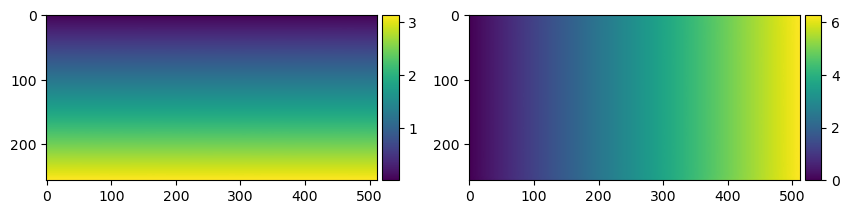

In [ ]:
import os
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"
import numpy as np
import healpy as hp
import pysht
from pysht import get_geom
import matplotlib.pyplot as plt
from delensalot.sims.sims_lib import Xunl, Xsky
from mpl_toolkits.axes_grid1 import make_axes_locatable

lmax, mmax = 255, 255
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) 

shape = hp.Alm.getsize(lmax, mmax)
synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
print(dlm.shape)

deflection_kwargs = {
    'nthreads': 10,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

backend = 'GPU'
geominfo_CAR = ('cc',{'nphi':2*(lmax+1), 'ntheta':lmax+1})
solver = 'cufinufft'
sht_solver = 'shtns' # 'shtns'
tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)

for mode in ['nuFFT']:
    print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
    t = pysht.get_transformer(solver, mode, backend)
    t = t(sht_solver, geominfo, deflection_kwargs)    

import ctypes
def pointing_GPU(self, synth_spin1_map):
    cuda_lib = ctypes.CDLL('/mnt/home/sbelkner/git/pySHT/pysht/c/pointing.so')
    cuda_lib.pointing.argtypes = [
        ctypes.POINTER(ctypes.c_float),
        ctypes.POINTER(ctypes.c_float),
        ctypes.POINTER(ctypes.c_int),
        ctypes.POINTER(ctypes.c_int),
        ctypes.POINTER(ctypes.c_double),
        ctypes.POINTER(ctypes.c_double),
        ctypes.c_int,
        ctypes.c_int,
        ctypes.POINTER(ctypes.c_double),
    ]
    cuda_lib.pointing.restype = None
    
    thetas_, phi0_, nphis_, ringstarts_ = self.geom.theta.astype(float), self.geom.phi0.astype(float), self.geom.nph.astype(int), self.geom.ofs.astype(int)
    red_, imd_ = synth_spin1_map.astype(np.double)
    npix_ = int(sum(nphis_))
    nrings_ = int(nphis_.size)
    output_array_ = np.zeros(shape=synth_spin1_map.size, dtype=np.double)

    thetas =        (ctypes.c_float * nrings_)(*thetas_)
    phi0 =          (ctypes.c_float * nrings_)(*phi0_)
    nphis =         (ctypes.c_int * nrings_)(*nphis_)
    ringstarts =    (ctypes.c_int * nrings_)(*ringstarts_)
    red =           (ctypes.c_double * npix_)(*red_)
    imd =           (ctypes.c_double * npix_)(*imd_)
    nrings =         ctypes.c_int(nrings_)
    npix =           ctypes.c_int(npix_)
    output_array = (ctypes.c_double * output_array_.size)(*output_array_)
    
    cuda_lib.pointing(thetas, phi0, nphis, ringstarts, red, imd, nrings, npix, output_array)
    # cuda_lib.pointing(thetas, phi0, nphis, ringstarts, red, imd, nrings, npix, output_array)
    
    ret = np.array(output_array, dtype=np.double)
    print("done: max value = {}, shape = {}".format(np.max(ret), ret.shape))
    _ = ret.reshape(synth_spin1_map.shape).T
    print(_.shape)
    return _

synth_spin1_map = t._build_d1(dlm, lmax, mmax)
ptg = pointing_GPU(t, synth_spin1_map)
np.sum(ptg[:,0].reshape(lmax+1,-1)[:,0]), ptg[:,0].reshape(lmax+1,-1)[:,0][:40]


fig, ax = plt.subplots(1,2, figsize=(10,6))

im = ax[0].imshow(ptg[:,0].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(ptg[:,1].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

/mnt/sw/nix/store/pmwk60bp5k4qr8vsg411p7vzhr502d83-openblas-0.3.23/lib:/cm/shared/apps/slurm/current/lib64
[SHTns 3.6.6] built Mar  8 2024, 10:43:50, id: v3.6.6*,avx512,ishioka,openmp,cuda
Could not import skcuda.fft
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 03-29 16:46:07:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-29 16:46:07:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 03-29 16:46:08:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-29 16:46:08:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
Running in debug mode
CPU_SHT_DUCC_transformer.synthesis
  Input shape: [(), (524800,)]
  Output shape: (2, 2097152)
Testing solver=cufinufft backend=GPU mode=nuFFT...
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (wa

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:522: RuntimeWarning: divide by zero encountered in divide
  synth_spin1_map = self.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1))))), nthreads=4)


nrings: 1024, npix: 2097152
thetas: 0.002347 0.100428 0.198554 0.296681 0.394808 0.492934 0.591061 0.689188 0.787315 0.885442 0.983568 1.081695 1.179822 1.277949 1.376076 1.474203 1.572330 1.670456 1.768583 1.866710 1.964837 2.062964 2.161091 2.259218 2.357344 2.455471 2.553598 2.651725 2.749851 2.847978 2.946105 3.044231 
phi0: 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
nphis: 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 
ringstarts: 0 65536 131072 196608 262144 327680 393216 458752 524288 589824 655360 720896 786432 851968 917504 983040 1048576 1114112 1179648 1245184 1310720 1376256 1441792 1507328 1572864 1638400 1703936 176947

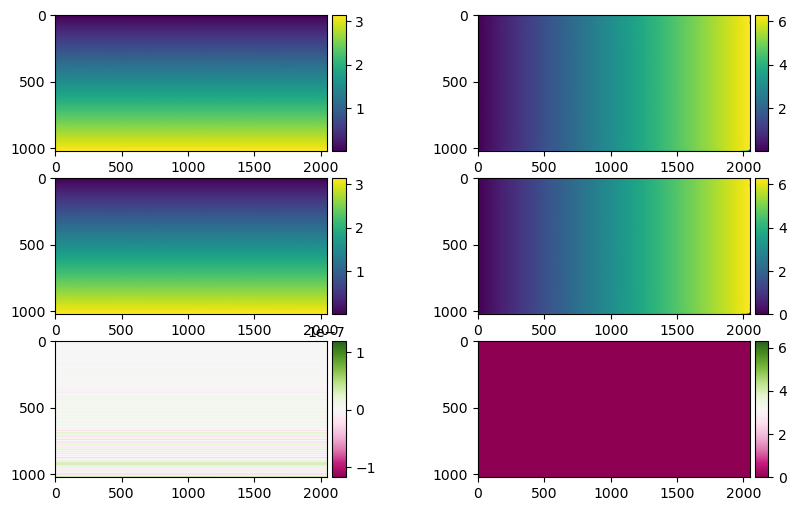

In [ ]:
import os
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"
import numpy as np
import healpy as hp
import pysht
from pysht import get_geom
import matplotlib.pyplot as plt
from delensalot.sims.sims_lib import Xunl, Xsky

from mpl_toolkits.axes_grid1 import make_axes_locatable

lmax, mmax = 1023, 1023
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
# geominfo = ('tgl',{'lmax': lmax, 'smax':3})
# geominfo = ('gl',{'lmax':lmax})
solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) # if solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
# geominfo = ('cc',{'nphi':1032, 'ntheta':2058})
# geominfo = ('healpix',{'nside': 512})

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')

deflection_kwargs = {
    'nthreads': 10,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

defres = {}
geominfo_CAR = ('cc',{'nphi':2*(lmax+1), 'ntheta':lmax+1})
for backend in ["CPU", "GPU"]:
    if backend == 'GPU':
        solvers = ['cufinufft']
        sht_solver = 'shtns' # 'shtns'
        tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)
    elif backend == 'CPU':
        solvers = ['duccnufft']
        sht_solver = 'ducc' # 'shtns'
        tCAR = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo_CAR)

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs) 
            print("\n----Testing function gclm2lenmap...----")
            defres.update({
            backend: t.gclm2lenmap(
            Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4, cc_transformer=tCAR, HAS_DUCCPOINTING=True, mode=2)})

for k in defres:
    print(k, defres[k][3].shape)
    print('-'*10)
fig, ax = plt.subplots(3,2, figsize=(10,6))

im = ax[0,0].imshow(defres['CPU'][3][:,0].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(defres['CPU'][3][:,1].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,0].imshow(defres['GPU'][3][:,0].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(defres['GPU'][3][:,1].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,0].imshow(defres['CPU'][3][:,0].reshape(lmax+1,-1) - defres['GPU'][3][:,0].reshape(lmax+1,-1), cmap='PiYG')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(defres['CPU'][3][:,1].reshape(lmax+1,-1) - defres['GPU'][3][:,1].reshape(lmax+1,-1), cmap='PiYG')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

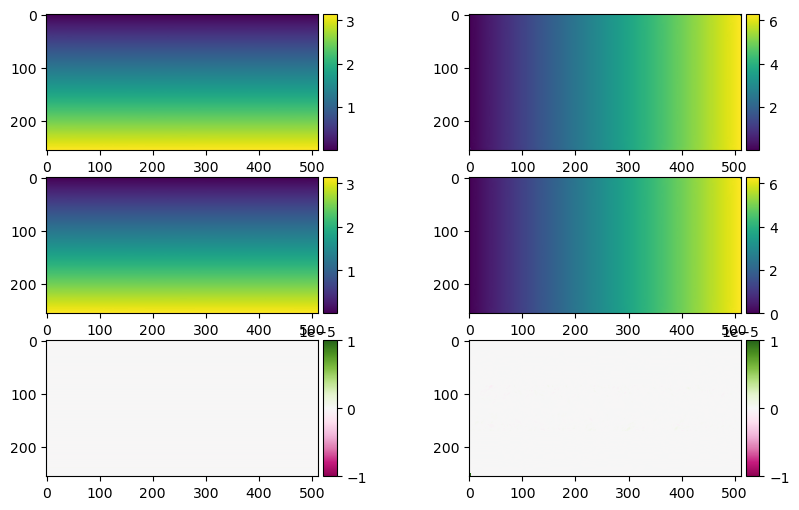

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,6))

im = ax[0,0].imshow(defres['CPU'][3][:,0].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(defres['CPU'][3][:,1].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,0].imshow(defres['GPU'][3][:,0].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(defres['GPU'][3][:,1].reshape(lmax+1,-1))
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,0].imshow(defres['CPU'][3][:,0].reshape(lmax+1,-1) - defres['GPU'][3][:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-5, vmax=1e-5)
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(defres['CPU'][3][:,1].reshape(lmax+1,-1) - defres['GPU'][3][:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-5, vmax=1e-5)
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
import shtns
geominfo_cc = ('cc',{'nphi':2*(2047+1), 'ntheta':2047+1})
c = shtns.sht(int(geominfo_cc[1]['ntheta']-1), int(geominfo_cc[1]['ntheta']-1))
c.set_grid(flags=shtns.sht_reg_dct + shtns.SHT_THETA_CONTIGUOUS)

